In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import struct
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pickle
from extractModel_mappings_linux import   allparams_from_mapping
import subprocess

def nrnMread(fileName):
    f = open(fileName, "rb")
    nparam = struct.unpack('i', f.read(4))[0]
    typeFlg = struct.unpack('i', f.read(4))[0]
    return np.fromfile(f,np.double)

data_dir ='../Data'


def nrnMreadH5(fileName):
    f = h5py.File(fileName,'r')
    dat = f['Data'][:][0]
    return np.array(dat)

In [11]:
paramsCSV = '../params/params_bbp_full.csv'
#orig_params = np.array(np.array(nrnUtils.readParamsCSV(paramsCSV))[:,1], dtype=np.float64)
orig_params = h5py.File('../params/params_bbp_full.hdf5', 'r')['orig_full'][0]
print(orig_params)
scores_path = '../scores/'
objectives_file = h5py.File('../objectives/multi_stim_bbp_full.hdf5', 'r')
opt_weight_list = objectives_file['opt_weight_list'][:]
opt_stim_name_list = objectives_file['opt_stim_name_list'][:]
opt_stim_list = [e.decode('ascii') for e in opt_stim_name_list]
score_function_ordered_list = objectives_file['ordered_score_function_list'][:]
stims_path = '../stims/stims_full.hdf5'
stim_file = h5py.File(stims_path, 'r')
#target_volts_path = './target_volts/allen_data_target_volts_10000.hdf5'
#target_volts_hdf5 = h5py.File(target_volts_path, 'r')
#params_opt_ind = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
params_opt_ind = np.arange(24) 
model_dir = '..'
data_dir = model_dir+'/Data/'
run_dir = '../bin'
#vs_fn = '/tmp/Data/VHotP'
vs_fn = '../Data/VHotP'
target_volts = np.genfromtxt("../Data/target_volts_BBP19.csv",delimiter = ',')
ntimestep = 10000

[8.00000000e-05 2.61450000e-02 4.22600000e-03 8.00000000e-05
 1.43000000e-04 3.13796800e+00 8.92590000e-02 2.91000000e-03
 6.82700000e-03 7.10400000e-03 9.90000000e-04 9.73538000e-01
 1.02194500e+00 2.87198731e+02 8.75200000e-03 6.09000000e-04
 3.03472000e-01 8.40700000e-03 9.94000000e-04 9.83955000e-01
 8.00000000e-05 2.10485284e+02 3.33000000e-04 3.00000000e-05]


In [3]:
import pandas as pd

def readParamsCSV(fileName):
    fields = ['Param name', 'Base value','Lower bound', 'Upper bound']
    df = pd.read_csv(fileName,skipinitialspace=True, usecols=fields)
    
    paramsList = [tuple(x) for x in df.values]
    return paramsList

In [4]:
import bluepyopt as bpop

opt_ind = np.arange(24) 
data = readParamsCSV(paramsCSV)
data = np.array([data[i] for i in opt_ind])
pmin = np.array((data[:,2]), dtype=np.float64)
pmax = np.array((data[:,3]), dtype=np.float64)
# make this a function
fixed = {}
params = []
for param_idx in range(len(orig_params)):
    if np.isclose(orig_params[param_idx],pmin[param_idx],rtol=.001) and np.isclose(pmin[param_idx],pmax[param_idx],rtol=.001):
        print(orig_params[param_idx], " idx : ", param_idx)
        fixed[param_idx] = orig_params[param_idx]
    else:
        params.append(bpop.parameters.Parameter(orig_params[param_idx], bounds=(pmin[param_idx],pmax[param_idx])))

8e-05  idx :  0
0.00291  idx :  7
287.198731  idx :  13
0.000609  idx :  15
210.485284  idx :  21


In [13]:
def run_model(stim_ind):
    """
    Parameters
    -------------------------------------------------------
    stim_ind: index to send as arg to neuroGPU 
    params: DEPRECATED remove

    Returns
    ---------------------------------------------------------
    p_object: process object that stops when neuroGPU done
    """
    #volts_fn = vs_fn + str(stim_ind) + '.dat'
    volts_fn = vs_fn + str(stim_ind) + '.h5'
    if os.path.exists(volts_fn):
        os.remove(volts_fn)
    p_object = subprocess.Popen(['../bin/neuroGPU',str(stim_ind)],
                    stdout=subprocess.PIPE, 
                    stderr=subprocess.STDOUT,  # <-- redirect stderr to stdout
                    bufsize=1)
    with p_object.stdout:
        for line in iter(p_object.stdout.readline, b''):
            print(line),
    p_object.wait()
    return p_object

###### TEN COPIES OF ORIG PARAMS FOR DEBUG #################
param_values =  np.array(orig_params).reshape(1,-1)
param_values = np.repeat(param_values, 10, axis=0)
print(param_values[0], "pvals shape!!!!!!!!")
###### TEN COPIES OF ORIG PARAMS FOR DEBUG #################

#allparams = allparams_from_mapping(list(param_values)) 
#run_model(1)

[8.00000000e-05 2.61450000e-02 4.22600000e-03 8.00000000e-05
 1.43000000e-04 3.13796800e+00 8.92590000e-02 2.91000000e-03
 6.82700000e-03 7.10400000e-03 9.90000000e-04 9.73538000e-01
 1.02194500e+00 2.87198731e+02 8.75200000e-03 6.09000000e-04
 3.03472000e-01 8.40700000e-03 9.94000000e-04 9.83955000e-01
 8.00000000e-05 2.10485284e+02 3.33000000e-04 3.00000000e-05] pvals shape!!!!!!!!


In [6]:
def getVolts(idx):
    '''Helper function that gets volts from data and shapes them for a given stim index'''
    fn = vs_fn + str(idx) +  '.h5'    #'.h5' 
    curr_volts =  nrnMreadH5(fn)
    #fn = vs_fn + str(idx) +  '.dat'    #'.h5'
    #curr_volts =  nrnMread(fn)
    Nt = int(len(curr_volts)/ntimestep)
    shaped_volts = np.reshape(curr_volts, [Nt,ntimestep])
    return shaped_volts

[8.00000000e-05 1.79922692e+00 2.01434217e-01 4.01899484e-03
 8.64794342e-03 2.23438361e+02 3.33848302e+00 2.91000000e-03
 5.81758859e-01 3.49159080e-01 1.36222981e-02 1.88224327e+01
 3.30357316e+00 2.87198731e+02 6.69145013e-01 6.09000000e-04
 4.58629921e-01 2.26931594e-01 4.10624101e-02 7.30480739e+01
 7.90595674e-03 2.10485284e+02 2.52347670e-02 1.98689132e-04]
[8.00000000e-05 2.61450000e-02 4.22600000e-03 8.00000000e-05
 1.43000000e-04 3.13796800e+00 8.92590000e-02 2.91000000e-03
 6.82700000e-03 7.10400000e-03 9.90000000e-04 9.73538000e-01
 1.02194500e+00 2.87198731e+02 8.75200000e-03 6.09000000e-04
 3.03472000e-01 8.40700000e-03 9.94000000e-04 9.83955000e-01
 8.00000000e-05 2.10485284e+02 3.33000000e-04 3.00000000e-05]


OSError: Unable to open file (unable to open file: name = '../Data/VHotP3.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

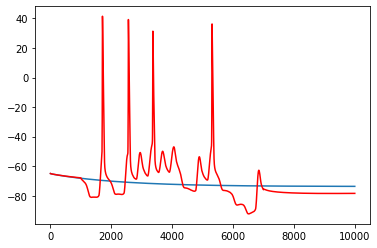

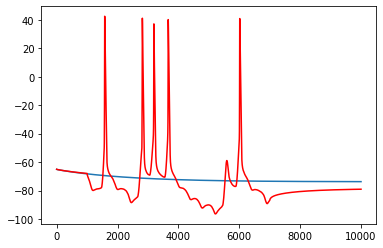

<Figure size 432x288 with 0 Axes>

In [7]:
#paramset = np.array(pickle.load( open( "../python/best_indv_logs/best_indvs_gen_10.pkl", "rb" ) ))
paramset = np.array(pickle.load( open( "../python/best_indvs_final_31_Oct_2020.pkl", "rb" ) ))
for reinsert_idx in fixed.keys():
    paramset = np.insert(np.array(paramset), reinsert_idx, fixed[reinsert_idx], axis = 1)

print(paramset[0])
print(orig_params)

nstims = len(opt_stim_list)

    
for i in range(1,8):
    plt.figure()
    curr_volts = getVolts(i)
    plt.plot(curr_volts[0])
    plt.plot(target_volts[i,:], color='Red')

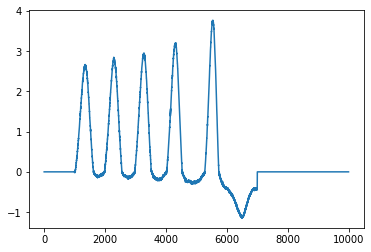

In [10]:
plt.plot(np.genfromtxt("../Data/Stim_raw14.csv"))